# Reusing Curves From SplineCloud

In [1]:
import bisect
import numpy as np
from splinecloud_scipy import load_spline
import matplotlib.pyplot as plt
%matplotlib notebook 

# 1. Load spline curve from SplineCloud

In [2]:
# data relation link: https://splinecloud.com/compose/dfl_3vkXGnuIRD8U/relations/drl_9LbgP3YUTOni
spline = load_spline('spl_4Wk6u6qyEgiA')

### Load underlying data points

In [3]:
header, data = spline.load_data()

In [4]:
print(header)
print(data[:10])

['Alpha', 'Cl', 'Cd', 'Cdp', 'Cm', 'Top_Xtr', 'Bot_Xtr']
[[-9.25    -0.4676   0.09591  0.09056 -0.0237   1.       0.1755 ]
 [-9.      -0.649    0.06371  0.0582  -0.0496   1.       0.1058 ]
 [-8.75    -0.6415   0.05994  0.05441 -0.0485   1.       0.1028 ]
 [-8.5     -0.649    0.05536  0.04969 -0.0471   1.       0.101  ]
 [-8.25    -0.6597   0.05048  0.04453 -0.0453   1.       0.0998 ]
 [-8.      -0.6647   0.04615  0.03984 -0.0432   1.       0.0994 ]
 [-7.75    -0.664    0.04234  0.03564 -0.041    1.       0.0995 ]
 [-7.5     -0.6588   0.03888  0.03177 -0.0389   1.       0.0996 ]
 [-7.25    -0.6495   0.03591  0.02836 -0.0369   1.       0.1001 ]
 [-7.      -0.637    0.03353  0.02555 -0.035    1.       0.102  ]]


### Evaluate spline as a function f(x)

In [5]:
cl = spline.eval(5.6)
cl

0.8591962852217998

### Evaluate spline for a range of x values

In [6]:
X = np.linspace(min(data[:,0]), max(data[:,0]), 100)
Y = spline.eval(X)

<IPython.core.display.Javascript object>


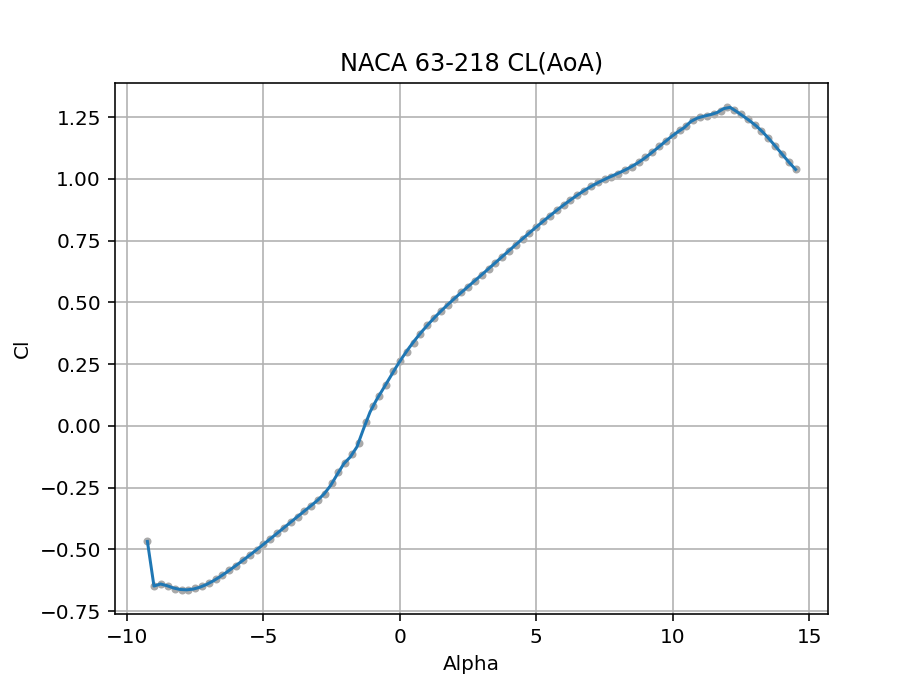

In [7]:
fig = plt.figure()
plt.scatter(data[:,0], data[:,1], color='darkgrey', marker=".")
plt.plot(X, Y)
plt.title("NACA 2412 CL(AoA)")
plt.xlabel(header[0])
plt.ylabel(header[1])
plt.grid()
plt.show()

### Evaluate fit accuaracy

In [8]:
RMSE = spline.fit_accuracy(data[:,:2], method="RMSE")
RMSE

0.0014689533377159833

In [9]:
MAE = spline.fit_accuracy(data[:,:2], method="MAE")
MAE

0.000971998945494264

## Find max y value on the curve

In [10]:
from scipy.optimize import minimize

In [11]:
objective_func = lambda x: -float(spline.eval(x))

In [12]:
cl_max = minimize(objective_func, [13]).x
cl_max

array([12.01917408])

# 2. Load collection of curves from SplineCloud

In [13]:
# link to data relations: https://splinecloud.com/compose/dfl_yRvfIsQYc80M/relations

curves = {
    0.02: load_spline("spl_qdcawsLtKQEE"),
    0.04: load_spline("spl_y9EgqGbxPnIq"),
    0.06: load_spline("spl_f3b0iOa9X7e0"),
    0.08: load_spline("spl_soc8JQBaJLHT")
}

### Construct response surface model using linear interpolation between curves

In [14]:
class ResponseSurface:
    
    def __init__(self, curves_collection, extrapolate=False):
        self.curves = curves_collection
        self.z_range = sorted(curves_collection.keys())
        self.func = self.get_linear_sweep_by_z(extrapolate)
    
    def get_linear_sweep_by_z(self, extrapolate=False):
        def interp_z(z, x):
            z_left, z_right = self.neighbor_z(z)
            
            y_left = self.curves[z_left].eval(x, extrapolate=extrapolate)
            y_right = self.curves[z_right].eval(x, extrapolate=extrapolate)
            
            y = (z-z_left)*(y_right-y_left)/(z_right-z_left) + y_left

            return y
        
        return interp_z
    
    def neighbor_z(self, z):
        idx = bisect.bisect_left(self.z_range, z)

        if idx == 0:
            return self.z_range[0], self.z_range[1]
        elif idx >= len(self.z_range):
            return self.z_range[-2], self.z_range[-1]
        else:
            return self.z_range[idx - 1], self.z_range[idx]


## Evaluate response surface model

In [15]:
resp_surf = ResponseSurface(curves)

resp_surf.func(0.045, 2.5)

0.33304926618716396

### Display response surface

<IPython.core.display.Javascript object>


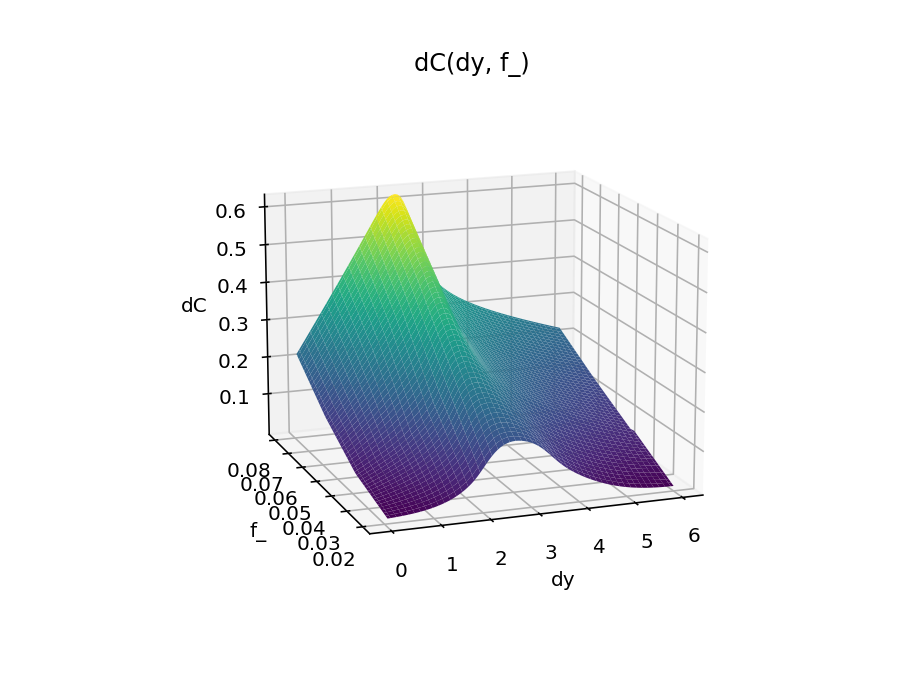

In [16]:
dy_range = np.linspace(0, 6, 100)
f_range = np.linspace(0.02, 0.08, 100)
dy_vals, f_vals = np.meshgrid(dy_range, f_range)
c_vals = np.array([[resp_surf.func(fv, dy) for dy in dy_range] for fv in f_range])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(dy_vals, f_vals, c_vals, cmap='viridis')
ax.set_title('dC(dy, f_)')
ax.set_xlabel('dy')
ax.set_ylabel('f_')
ax.set_zlabel('dC')
ax.view_init(elev=15., azim=250.0)
plt.show() 